In [1]:
%matplotlib notebook

import pyn.advanced_command as m

Bonjour,

Je voulais prendre quelques minutes pour vous présenter ceci. J'espère pouvoir en discuter de vive voix avec Nicolas à la rentrée... mais en attendant, je voulais un petit support, le voilà. De votre réponse dépendra les limites à imposer à la dynamique du `PFCP`, pour chacun des axes.

**Pour avoir accès aux vignettes interactives, faire : Kernel > Restart & Run All**

## Introduction

Entre l'`UPMV` (la navigation) et le `PFCP` (le contrôle) transitent des commandes de haut niveau: Psi, Vz, IAS, etc. et je reste convaincu que c'est la meilleure façon de procéder :

* parce que cela permet un bon niveau d'abstraction et cela facilite l'introduction de limitations côté PFCP, qui sécurisent la partie contrôle.
* parce que piloter des ordres de plus bas niveau pose d'autres problèmes, avec des boucles de feeback en oignon (d'autant plus génantes que les deux logiciels tournent ici sur des plateformes différentes)

Ce choix pose pourtant un paradoxe qui m'est apparu alors que je cherchais à suivre des trajectoires suffisamment précises pour respecter nos contraintes (corridors, etc.). Je vais essayer d'en exposer les tenants et les aboutissants, puisque que ce problème pourrait se poser dans tout autre système basé sur des ordres de haut niveau.

## La boucle complète

Pour faire simple, voici un schéma de l'organisation de nos codes respectifs.

![loop upmv + pfcp](img/full_loop.png)

Je prendrais ici quelques hypothèses quant à l'organisation de votre système, si elles s'avèrent légèrement fausses, veuillez m'en excuser, les conclusions devraient cependant rester valides.

Par exemple, je suppose que $X_{ref}$, $\dot X_{ref}$ et, éventuellement, $\ddot X_{ref}$ sont présents à l'entrée de votre feedforward.

## Gestion des limitations
Je suppose également que les limitations agréées entre nous sont appliquées au niveau d'un _générateur de trajectoire_. Et l'hypothèse est faite qu'il s'agit d'un filtre d'ordre 2 du genre décrit ci-dessous, muni d'une saturation avant $\ddot X_{ref}$ et d'une autre avant $\dot X_{ref}$ :

![saturated filter](img/second_order_trajectory.png)

Vous trouveez ci dessous un implémentation illustrée de ce type de filtre (avec `Xref filtered` la réponse du filtre classique du second ordre et `Xref saturated` la réponse du même filtre avec les saturations).

<IPython.core.display.Javascript object>


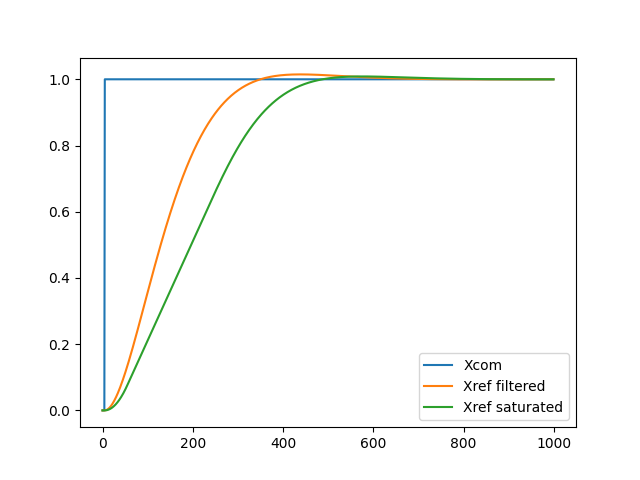

interactive(children=(FloatSlider(value=0.8, description='epsilon', max=2.0, min=0.2), FloatSlider(value=12.0,…

In [2]:
m.saturated_filter_demo()

## Filtrage des trajectoires

Même dans le cas ou l'`UPMV` générerait une commande qui respecte parfaitement les limites agréées, on constate ci dessous qu'un retard non négligeable est introduit entre `Xcom` et `Xref`.

Dans l'example qui suit, les paramètres du générateur de trajectoire du `PCFP` ont été figés sur `epsilon = 0.8`, `omega0 = 10.0`, `sat1 = 3.0` et `sat2 = 60.0`. Les paramètres de l'UPMV sont initialisé sous ces mêmes conditions mais sont ajustables via les réglettes.

L'erreur de commande, celle qui doit être rattrappée par le feedback de l'`UPMV`, correspond à l'aire entre les deux courbes. On peut aisément constater que même en réduisant la dynamique de `Xcom` cette erreur change peu et reste importante.

La raison principale est que votre générateur de trajectoire n'a aucune connaissance du fait que la commande n'est pas en régime établi (avec une dérivée nulle) mais est en fait en pleine transition.

En pointillé, on peut voir les trajectoire que l'on obtiendrai si au point courant, le régime établit était atteint. Et on peut voir que la réponse $X_ref$ avant ce point est exactement supperposable à la réponse complète du filtre.

<IPython.core.display.Javascript object>


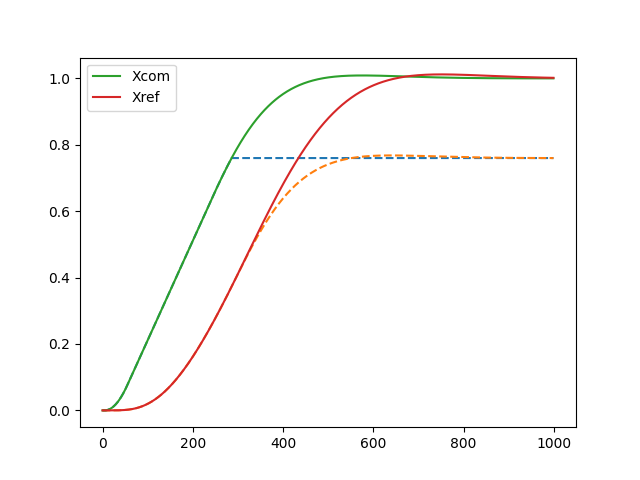

interactive(children=(FloatSlider(value=0.8, description='epsilon', max=2.0, min=0.2), FloatSlider(value=12.0,…

In [3]:
m.successive_filter_demo()

## Le paradoxe

Essayant de trouver la meilleure façon de conserver de la précision, au prix d'une eventuelle vitesse d'exécution, j'ai modifié mes ordres envoyés au PFCP afin de prendre encore plus de marge vis-à-vis des limites agréées, mais comme vous avez pu le constater en jouant avec les sliders ci-dessus, cela n'a eu que peu d'impact sur l'aire totale entre les deux courbes. Dans le cas du Psi, cette erreur coûte vite cher !

Le paradoxe est donc le suivant:

* quelle que soit la dynamique du générateur de trajectoire, on peut toujours trouver une trajectoire pilotées `Xcom` qui respecte les limites agréées et qui reste dans le corridor (au prix, éventullement, d'une vitesse de déplacement plus faible)
* encore mieux ! plus la dynamique du générateur de trajectoire est faible et plus j'ai l'assurance que l'erreur entre `Xref` et `Xmes` sera faible (puisque la dynamique de l'hélicoptère reste la même, plus les commandes seront limitées, plus le système sera en mesure de les respecter)
* mais plus le retard imposé le générateur de trajectoire augmente (et moins il reste de marge pour corriger avec le feedback de l'`UPMV`)

Lorsque la dynamique baisse, alors que la partie contrôle est de plus en plus précise, la partie navigation l'est de moins en moins.

Mais il y a une solution !

## Une proposition

Il faut s'assurer, d'une façon ou d'une autre, que soit pris en compte le fait que la commande est en train d'évoluer et n'est pas en régime établi.

La solution idéale, pour moi, serait de modifier votre générateur de trajectoire pour qu'il accepte de prendre en entrée $X_{com}$ ET $\dot{X_{com}}$. Ceci suffirait à faire disparaître ce retard de boucle. _(Personnelement c'est ce que j'utilise, un générateur de trajectoire qui accepte les dérivées et offre tout de même des limitations sur $\dot X_{ref}$ et $\ddot X_{ref}$)_

Une autre solution, qui pourrait être un bon intermédiaire de test, consisterait à brancher les commandes provenant de l'`UPMV` en entrée du feedforward directement (avec une éventuelle limitations simple sur les commandes et leurs dérivées)